# Cross Stitch Patterns from Images

This code will create a counted cross-stitch pattern from an image by pixellating it, determining color maps and replacing each pixel by an x in the designated color.  One can choose how many different colors to allow for a given image so that it is possible to minimize the complexity.  A color count of stitches will also be reported so the relative amounts of different color threads can be determined.

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Load image file

In [2]:
import scipy.ndimage as ndi
from scipy.misc import imresize
import requests
from StringIO import StringIO


In [3]:
response = requests.get("http://upload.wikimedia.org/wikipedia/commons/1/1c/CMS_Higgs-event.jpg")
pic = ndi.imread(StringIO(response.content))
print type(pic)

<type 'numpy.ndarray'>


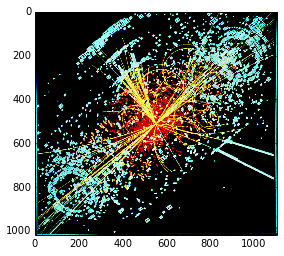

In [4]:
plt.imshow(pic);

In [5]:
print pic.shape
print pic[100,100]

(1018, 1104, 3)
[0 0 0]


Cross-stitching is done with a material called "Aida Cloth".  The size of the weave is measured by how many stitches can be made in one inch. This is called the fabric's count. The most common counts in Aida Cloth are 11, 14, 18 and 28. The higher the number, the smaller the stitches will be, because there are more stitches in each inch. 

For a 20 inch by 20 inch picture, using 14 count Aida Cloth, you have 280 stitches by 280 stitches.  

If you want to reproduce a picture pixel for pixel, divide the number of pixels in a given dimension by the fabric count for the Aida Cloth you intend to use.  That will show you how large the resulting pattern will be.  e.g. for the Higgs event shown above, with 28 count Aida cloth, the image will be 39 x 36 inches - 3 feet by 3 feet.  

# Image adjustment

In [6]:
#resize image
def resize(image,scale=25):
    """scale = % to resize.  This seems to also convert the 0-1 colors to integer RGB"""
    return imresize(image,scale,mode="RGB")

In [7]:
import scipy as sp
from scipy.cluster.vq import kmeans,vq
from sklearn.utils import shuffle

In [8]:
#Kmeans algorithm to reduce number of colors
def reduce_colors(image, k):
    '''Apply kmeans algorithm.
   Input:  image, number of clusters to use
   Output: colors, counts per color, new image'''
    if k > 24:
        k = 24
        print "Setting colors to maximum allowed of 24"
    rows, cols, rgb = image.shape
    # reshape the image in a single row array of RGB pixels
    image_row = np.reshape(image,(rows * cols, 3))
    #HERE ADD CODE TO GET A GOOD GUESS OF COLORS AND PASS THAT AS
    #SECOND ARGUMENT TO kmeans
    #image_array_sample = shuffle(image_row, random_state=0)[:1000]
    #kguess = kmeans(image_array_sample, k)
    #colors,_ = kmeans(image_row, kguess)
    # perform the clustering
    colors,_ = kmeans(image_row, k)
    # vector quantization, assign to each pixel the index of the nearest centroid (i=1..k)
    qnt,_ = vq(image_row,colors)
    # reshape the qnt vector to the original image shape
    image_centers_id = np.reshape(qnt,(rows, cols))
    # assign the color value to each pixel
    newimage = colors[image_centers_id]
    #count number of pixels of each cluster color
    counts,bins = sp.histogram(qnt, len(colors))
    return colors, counts, newimage

#JLK: Look into providing an array of RGB values corresponding to 
#available floss and using those to determine the clustering

# Color/Floss counting

In [153]:
#count colors
def color_count(image):
    """Considering a (w,h,3) image of (dtype=uint8),
    compute the number of unique colors
    
    Encoding (i,j,k) into single index N = i+R*j+R*C*k
    Decoding N into (i,j,k) = (N−k*R*C−j*R, (N−k*R*C)/R, N/(R*C))
          using integer division
    \n"""
    #Need to convert image to uint32 before multiplication so numbers are not truncated
    F = uint32(image[...,0])*256*256 + uint32(image[...,1])*256 + uint32(image[...,2])
    unique, counts = np.unique(F, return_counts=True)
    colors = np.empty(shape=(len(unique),3),dtype=uint32)
    numcol = np.empty(len(unique),dtype=uint32)
    i = 0
    for col,num in zip(unique,counts):
        R = col/(256*256)
        G = (col-R*256*256)/256
        B = (col-R*256*256-G*256)
        colors[i] = (R,G,B)
        numcol[i] = num
        i+=1
    return colors, numcol


In [81]:
#Found an online RGB<-->DMC floss color conversion table to reference.
def load_floss_colors(example=True):
    values = np.loadtxt('DMCtoRGB_JLK.txt', delimiter=' , ',dtype=int, usecols=[0,2,3,4])
    labels = np.loadtxt('DMCtoRGB_JLK.txt', delimiter=' , ',dtype=str, usecols=[1,5])
    if example:
        print "Example: ",values[27],labels[27]
    return values,labels

In [11]:
#Use distance in RGB space to determine closest color match
def match_color(rgb,method="Euclidean"):
    """for a given r,g,b tuple, determine the closest DMC thread color"""
    values,labels = load_floss_colors(False)
    #Use color metric from http://www.compuphase.com/cmetric.htm
    rmean = (rgb[0]-values[:,1]) / 2.
    r = rgb[0]-values[:,1]
    g = rgb[1]-values[:,2]
    b = rgb[2]-values[:,3]
    match = np.sqrt(((2+rmean/256.)*r*r) + 4*g*g + (((2 + (255-rmean)/256.)*b*b)))
    #return values[match.argmin()],labels[match.argmin()]
             
    #Compute distance to nearest color in RGB space
    rdiff2 = (rgb[0]-values[:,1])**2
    gdiff2 = (rgb[1]-values[:,2])**2
    bdiff2 = (rgb[2]-values[:,3])**2
    cdiff = np.sqrt(rdiff2+gdiff2+bdiff2)
    #print "Input rgb: ",rgb,"\tClosest match:",values[cdiff.argmin()],labels[cdiff.argmin()]

    if method == "Euclidean":
        return values[cdiff.argmin()],labels[cdiff.argmin()]
    else:
        return values[match.argmin()],labels[match.argmin()]

In [231]:
def yardskeincount(counts,aidasize):
    """Given an array of stitch counts and an aida cloth
    size, calculate and return the number of skeins and yards of
    floss for each"""
    #floss length per stitch for given count aida cloth
    boxsize = 25.4/aidasize #mm
    #diagonal of box
    boxdiag = np.sqrt(2*boxsize**2)
    threadperstitch = 2*boxdiag + 2*boxsize
    threadperstitch *= 1.2 #increase by 20% to account for extras and gaps between stitches
    
    threadpercolor = counts*threadperstitch/1000. #number of meters of floss needed in each color
    #floss comes in skeins of 8.7 yards of 6-stranded thread.  Typical 14-count patterns take 2 strands
    flosslength = 3*8.7*0.9144 #convert yards of 6-stranded thread to meters of 2-stranded thread
    #yards of 6-stranded thread
    yardspercolor = threadpercolor*0.9144
    skeinspercolor = threadpercolor/flosslength # need to round up
    return yardspercolor,skeinspercolor

In [232]:
#Print and return the matched floss counts
def floss_color_counts(colors,counts,aidasize=14):
    '''print the matched floss colors and counts'''
    mycounts = counts.copy() #copy so we don't mess up the original arrays
    inds = mycounts.argsort()
    sortedcolors = colors[inds].copy() #copy so we don't mess up the original arrays
    mycounts.sort()
    
    yds,skeinspercolor = yardskeincount(mycounts,aidasize)
    
    #Create a list of skein color count, code, and name
    summary = []
    print "Counts\tRGBColor\tFloss#\tFlossRGB\t#Skeins\tFlossName"
    print "====================================================================================="    
    for i in range(len(counts)-1,-1,-1):
        matches = match_color(sortedcolors[i])
        print mycounts[i],"\t",sortedcolors[i],"\t",matches[0][0],"\t",matches[0][1:],"\t %.2f"%skeinspercolor[i],"\t",matches[1]
        summary.append((float("%.2f"%skeinspercolor[i]),matches[0][0],matches[1][0],(sortedcolors[i]),(matches[0][1:])))

    #Here condense any duplicates in the summary?
    
    return summary

In [13]:
#replace color at x,y coordinates (in pixel space) with floss color RGB to check the image fidelity
def replace_color(image,color,match):
    print color,"\t--->\t",match
    indices = np.where(np.all(image == color, axis=-1))
    #print image[indices[0],indices[1]]
    image[indices[0],indices[1]] = match
    #print image[indices[0],indices[1]]


# Utilities

In [464]:
#Print some useful pattern info
def aida_size(pic,aida=14):
    """Given an Aida cloth count and an image of a given number of pixels,
    report the size of the resulting pattern in inches"""
    y,x,col = pic.shape
    print "Pixel dimensions: (%d x %d)"%(x,y)
    print "Aida Cloth count: %d"%aida
    print "Pattern dimensions: (%.2f in x %.2f in)"%(x/float(aida),y/float(aida))
    print "Pattern colors: %d"%(color_count(pic)[1]).size
    return x/float(aida), y/float(aida)

In [461]:
#Plot the image before and after manipulation
def plot_before_after(before,after,text="Transformed"):
    cb = color_count(before)[0].size
    ca = color_count(after)[0].size
    # Two subplots, the axes array is 1-d
    f, axarr = plt.subplots(1,2,figsize=(12, 6))
    axarr[0].imshow(before)
    axarr[0].set_title('Original image (%d colors)'%cb)
    axarr[1].set_title('%s image (%d colors)'%(text,ca))
    axarr[1].imshow(after);

#Applied to Data 

## Resize the image

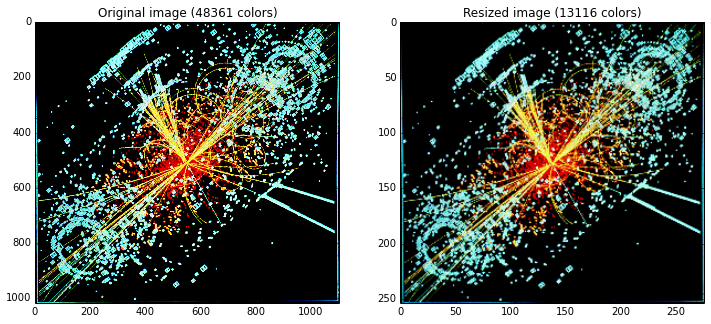

In [16]:
before = pic
smaller = resize(pic)
plot_before_after(before,smaller,"Resized")

---

#Apply color algorithm

In [17]:
#Takes a while.  We might try seeding the kmeans with decent guesses, 
#similar to what is done in scikit-learn
colors, counts, after = reduce_colors(smaller, 32)

Setting colors to maximum allowed of 24


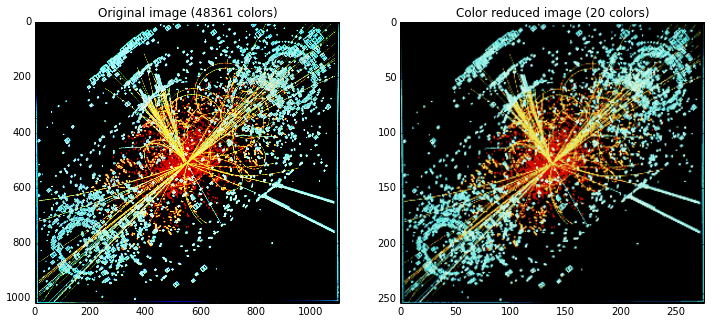

In [18]:
plot_before_after(before,after,"Color reduced")

# Show the results of the color match

In [233]:
#Counts of each color in RGB
summary = floss_color_counts(colors,counts)
#print summary

Counts	RGBColor	Floss#	FlossRGB	#Skeins	FlossName
38473 	[0 0 0] 	310 	[0 0 0] 	 16.95 	['Black' '000000']
7584 	[3 2 3] 	310 	[0 0 0] 	 3.34 	['Black' '000000']
3697 	[149 237 228] 	964 	[169 226 216] 	 1.63 	['Sea Green Light ' 'A9E2D8']
3372 	[206 244 228] 	828 	[197 232 237] 	 1.49 	['Sky Blue Vy Lt ' 'C5E8ED']
1863 	[236 229  89] 	3819 	[224 232 104] 	 0.82 	['Moss Green Lt ' 'E0E868']
1798 	[ 86 226 221] 	959 	[ 89 199 180] 	 0.79 	['Sea Green Med ' '59C7B4']
1213 	[216 180  42] 	729 	[208 165  62] 	 0.53 	['Old Gold Medium ' 'D0A53E']
1156 	[ 4 12 32] 	310 	[0 0 0] 	 0.51 	['Black' '000000']
1137 	[42  6  3] 	3371 	[30 17  8] 	 0.50 	['Black Brown ' '1E1108']
1134 	[ 51 176 173] 	958 	[ 62 182 161] 	 0.50 	['Sea Green Dark ' '3EB6A1']
1067 	[218   9   4] 	817 	[187   5  31] 	 0.47 	['Coral Red Very Dark' 'BB051F']
991 	[ 31 118 135] 	3765 	[ 52 127 140] 	 0.44 	['Peacock Blue Vy Dk ' '347F8C']
887 	[113 124  38] 	730 	[130 123  48] 	 0.39 	['Olive Green V Dk ' '827B30']
860 	[29

In [465]:
sizex,sizey = aida_size(test,aida=14)

Pixel dimensions: (276 x 254)
Aida Cloth count: 14
Pattern dimensions: (19.71 in x 18.14 in)
Pattern colors: 18


#Replace colors with matched floss colors 

In [154]:
finalunique, finalcount = color_count(test)

In [ ]:
#Make symbol part of the floss color file?
symbol = [r'\star',r'\vartriangle',r'\circ',r'\diamond',r'\pi',r'\phi',
          r'\alpha',r'\ominus',r'\oplus',r'\otimes',r'\odot',r'\times',
          r'\pitchfork',r'\bowtie',r'\plus',r'\minus',r'\sim',r'\vartriangleright',
          r'\oslash',r'\ast',r'\nu',r'\aleph',r'\asymp',r'\blacktriangle']

symb = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
        'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
        '-','|','/','\',r'\@',r'\#',r'\$',r'\%',r'\^',r'\&',r'\*',r'\(',r'\)',r'\<',r'\>','1','2','3','4','5','6',
        '7','8','9','.']

In [453]:
pattern_name = "Higgs Boson Event"
designer_name = "StitchIt"
aidacolor = 'black'

In [470]:
def color_dictionary(colors,counts,aidasize=14):
    yards,skeins = yardskeincount(counts,aidasize)
    values,labels = load_floss_colors(False)
    
    plt.figure(row,figsize=(7.5,10.))
    ax = plt.axes([0.025, 0.025, 0.95, 0.95],frameon=False)
    ax.set_xlim(0,1) 
    ax.set_ylim(0,1)
    plt.text(0.1,0.9,"Pattern Name:",fontweight='bold')
    plt.text(0.28,0.9,"%s"%pattern_name)
    plt.text(0.1,0.87,"Stitches:",fontweight='bold')
    plt.text(0.21,0.87,"%dw x %dh (2 strands, full)"%(after.shape[1],after.shape[0]))
    plt.text(0.1,0.84,"Finished Size:",fontweight='bold')
    plt.text(0.27,0.84,"%.1fw x %.1fh (inches)"%(sizex,sizey))
    plt.text(0.65,0.9,"Designed by:",fontweight='bold')
    plt.text(0.81,0.9,"%s"%designer_name)
    plt.text(0.65,0.87,"Fabric:",fontweight='bold')
    plt.text(0.74,0.87,"%s-ct %s aida"%(aidasize,aidacolor))
    plt.text(0.1,0.78,"DMC")
    plt.text(0.25,0.78,"Symbol")
    plt.text(0.4,0.78,"Color")
    plt.text(0.5,0.78,"Skeins")
    plt.text(0.65,0.78,"Description")
    plt.plot((0.08,0.9),(0.775,0.775),"k")
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    yspace = 0.03
    i = 1
    for col,yc,sc in zip(colors,yards,skeins):
        #Find the index where color appears in the floss list
        index = np.where(np.all(values[:,1:] == col, axis=-1))
        print "DMC:",values[index[0],0][0],"\tYards: %.1f"%yc,"\tSkeins: %.1f"%sc,"\t(FlossRGB:",values[index[0],1:][0],")","\tName:",labels[index[0],0][0] 
        plt.text(0.1,0.78-i*yspace,"%d"%values[index[0],0][0],ha='left')
        plt.text(0.275,0.78-i*yspace,"foo")
        plt.plot(0.28,0.78-(i-0.1)*yspace+0.0025, 's',markersize=10,markerfacecolor='None')
        plt.plot(0.425,0.78-(i-0.1)*yspace+0.0025, 's',markersize=10,markerfacecolor=(col[0]/255.,col[1]/255.,col[2]/255.))
        plt.text(0.56,0.78-i*yspace,"%.0f"%ceil(sc),ha='right')
        plt.text(0.65,0.78-i*yspace,"%s"%labels[index[0],0][0])
        
        i += 1
        

DMC: 310 	Yards: 453.8 	Skeins: 20.8 	(FlossRGB: [0 0 0] ) 	Name: Black
DMC: 909 	Yards: 7.8 	Skeins: 0.4 	(FlossRGB: [ 21 111  73] ) 	Name: Emerald Green Vy Dk 
DMC: 890 	Yards: 8.3 	Skeins: 0.4 	(FlossRGB: [23 73 35] ) 	Name: Pistachio Grn Ult V D 
DMC: 939 	Yards: 7.0 	Skeins: 0.3 	(FlossRGB: [27 40 83] ) 	Name: Navy Blue Very Dark 
DMC: 3371 	Yards: 10.9 	Skeins: 0.5 	(FlossRGB: [30 17  8] ) 	Name: Black Brown 
DMC: 3765 	Yards: 9.5 	Skeins: 0.4 	(FlossRGB: [ 52 127 140] ) 	Name: Peacock Blue Vy Dk 
DMC: 958 	Yards: 10.9 	Skeins: 0.5 	(FlossRGB: [ 62 182 161] ) 	Name: Sea Green Dark 
DMC: 959 	Yards: 17.3 	Skeins: 0.8 	(FlossRGB: [ 89 199 180] ) 	Name: Sea Green Med 
DMC: 3857 	Yards: 8.2 	Skeins: 0.4 	(FlossRGB: [104  37  26] ) 	Name: Rosewood Dark 
DMC: 730 	Yards: 8.5 	Skeins: 0.4 	(FlossRGB: [130 123  48] ) 	Name: Olive Green V Dk 
DMC: 954 	Yards: 7.9 	Skeins: 0.4 	(FlossRGB: [136 186 145] ) 	Name: Nile Green  
DMC: 816 	Yards: 7.6 	Skeins: 0.3 	(FlossRGB: [151  11  35] ) 	Nam

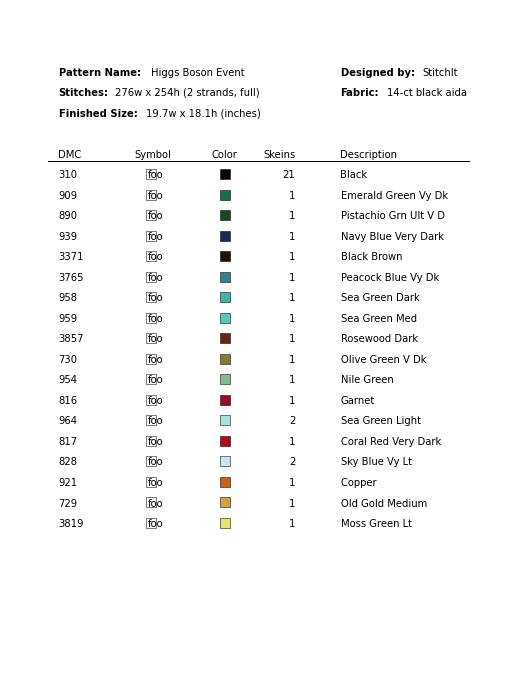

In [471]:
color_dictionary(finalunique,finalcount)

Replacing image colors with matched floss color:
[0 0 0] 	--->	[0 0 0]
[3 2 3] 	--->	[0 0 0]
[149 237 228] 	--->	[169 226 216]
[206 244 228] 	--->	[197 232 237]
[236 229  89] 	--->	[224 232 104]
[ 86 226 221] 	--->	[ 89 199 180]
[216 180  42] 	--->	[208 165  62]
[ 4 12 32] 	--->	[0 0 0]
[42  6  3] 	--->	[30 17  8]
[ 51 176 173] 	--->	[ 62 182 161]
[218   9   4] 	--->	[187   5  31]
[ 31 118 135] 	--->	[ 52 127 140]
[113 124  38] 	--->	[130 123  48]
[29 62 21] 	--->	[23 73 35]
[91 18  7] 	--->	[104  37  26]
[212  96  22] 	--->	[198  98  24]
[142 192 141] 	--->	[136 186 145]
[26 92 80] 	--->	[ 21 111  73]
[153  16   5] 	--->	[151  11  35]
[ 8 35 76] 	--->	[27 40 83]


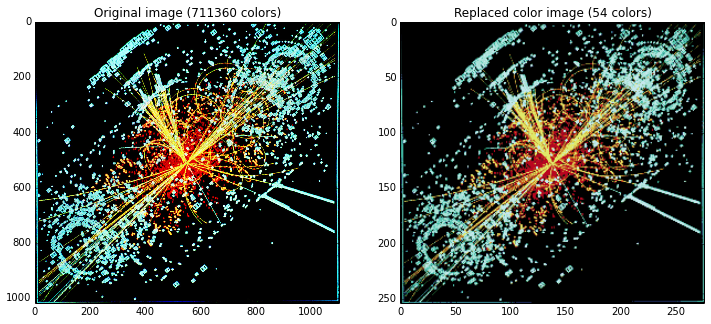

In [322]:
#Use a copy so we don't mess with the original reduced image
test = after.copy()
print "Replacing image colors with matched floss color:"
for (skeins, floss, name, oldcolor, matchedcolor) in summary:
    #print skeins,"\t",name,"\t",floss
    #print matchedcolor
    replace_color(test,oldcolor,matchedcolor)

plot_before_after(before,test,"Replaced color")

##Hmmmm....

Much better color match with new DMC RGB mapping.

In [22]:
def view_colors(summary):
    vals,labs = load_floss_colors(example=False)
    fig = plt.figure(1,figsize=(15,15))
    plt.axes()

    count = 0
    #Plot original and matched colors
    for (skeins, floss, name, oldcolor, matchedcolor) in summary:
        circle = plt.Circle((count, 26), radius=0.5, fc=(oldcolor[0]/255.,oldcolor[1]/255.,oldcolor[2]/255.));
        plt.gca().add_patch(circle)
        plt.plot([-2,27],[25.5,25.5],"k")
        circle2 = plt.Circle((count, 25), radius=0.5, fc=(matchedcolor[0]/255.,matchedcolor[1]/255.,matchedcolor[2]/255.));
        plt.gca().add_patch(circle2)
        plt.text(count,24,floss,va='center', ha='center',fontsize=10)
        count += 1

    plt.text(17,25.75,"Original Colors",fontsize=15)
    plt.text(17,24.75,"Matched Floss",fontsize=15)
    plt.text(-6,22,"DMC Flosses:",fontsize=15)
    
    #Plot available floss colors
    for i in range(len(vals)):
        row=i/20
        col=i%20
        circle = plt.Circle((col, row), radius=0.5, fc=(vals[i,1]/255.,vals[i,2]/255.,vals[i,3]/255.));
        plt.gca().add_patch(circle)
        plt.text(col,row,vals[i,0],va='center', ha='center',fontsize=10)
        plt.axis('scaled')
    plt.xlim(-2,22)
    plt.ylim(-2,27)
    plt.show()

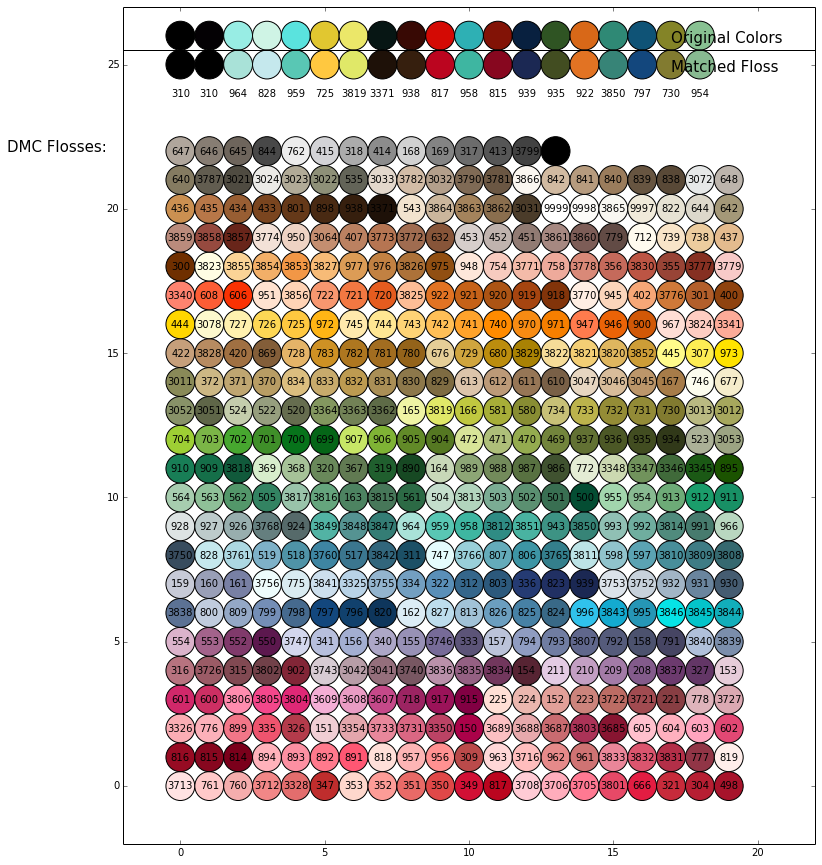

In [37]:
view_colors(summary)

---

# Create pattern

Now that the size and colors have been reduced, represent each color by a character and plot those characters on a 2-D grid representing the image.

In [23]:
#retrieve x,y coordinates (in pixel space) of all pixels of a given color
def locate_color(image,color):
    indices = np.where(np.all(image == color, axis=-1))
    #print zip(indices[0], indices[1])
    return indices[1], indices[0] #row,col vs. x,y

In [24]:
#plot symbols corresponding to different values
symbol = [r'\star',r'\vartriangle',r'\circ',r'\diamond',r'\pi',r'\phi',
          r'\alpha',r'\ominus',r'\oplus',r'\otimes',r'\odot',r'\times',
          r'\pitchfork',r'\bowtie',r'\plus',r'\minus',r'\sim',r'\vartriangleright',
          r'\oslash',r'\ast',r'\nu',r'\aleph',r'\asymp',r'\blacktriangle']

#print symbol
#print len(summary)
#symbol = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'o', '*', 'c', 'x', 'n', 'z']

import matplotlib.colors as mplcolors
mpc = []
for name, hex in matplotlib.colors.cnames.iteritems():
    mpc.append(name)

In [25]:
#Figure out how to parse it into 8.5x11 paper
#each paper has 7.5 inches of width to work with and 10 inches of height

wp,hp = 7.5,10. #printable paper width,height
cmperinch = 2.54 #cm
print "Printable width: %.2f cm"%(wp*cmperinch) #convert paper-width to cm
print "Printable height: %.2f cm"%(hp*cmperinch) #convert paper-height to cm

boxespercm = 4 # 0.25mm per side
numpix_x = int(np.floor(wp*cmperinch*boxespercm))
numpix_y = int(np.floor(hp*cmperinch*boxespercm))
print "Pixels in x: %d"%numpix_x
print "Pixels in y: %d"%numpix_y

Printable width: 19.05 cm
Printable height: 25.40 cm
Pixels in x: 76
Pixels in y: 101


Given the numbers, let's round to 80x100 grid boxes with a border of 10

Portrait:
xdim: 276 pixels / 80 pxperpg = 4 pages
ydim: 254 pixels / 100 pxperpg = 3 pages
[[70 80 80 46]
 [70 80 80 46]
 [70 80 80 46]] 
276
[[ 90  90  90  90]
 [100 100 100 100]
 [ 64  64  64  64]] 
254


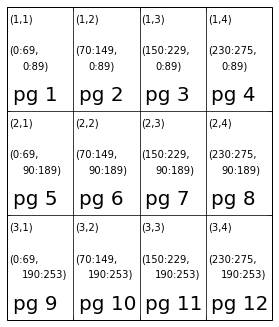

In [26]:
#How many pieces of paper do we need?
gridx = 80 #max px in x direction
gridy = 100 #max px in y direction
border = 10 #grid box border
pgsx = int(np.ceil(after.shape[1]/float(gridx)))
pgsy = int(np.ceil(after.shape[0]/float(gridy)))

print "Portrait:"
print "xdim: %d pixels / %d pxperpg = %d pages"%(after.shape[1],gridx,pgsx)
print "ydim: %d pixels / %d pxperpg = %d pages"%(after.shape[0],gridy,pgsy)

pxperpg_x = np.zeros([pgsy, pgsx],dtype=int)+80
pxperpg_y = np.zeros([pgsy, pgsx],dtype=int)+100
#leftmost pages have 70 px in x, next n have 80 each, rightmost have remainder
#topmost pages have 90 px in x, next n have 100 each, bottommost have remainder
pxperpg_x[:,0] -= 10; pxperpg_x[:,-1] = after.shape[1]-pxperpg_x[0,0:-1].sum()
pxperpg_y[0,:] -= 10; pxperpg_y[-1,:] = after.shape[0]-pxperpg_y[0:-1,0].sum()
print pxperpg_x,"\n",pxperpg_x[0].sum()
print pxperpg_y,"\n",pxperpg_y[:,0].sum()

plt.figure(27,figsize=(4*sizex/sizey,4*sizey/sizex))
ax = plt.axes([0,0,1,1])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.xaxis.set_major_locator(plt.MultipleLocator(1/4.))
ax.yaxis.set_major_locator(plt.MultipleLocator(1/3.))
ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='k')
ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='k')

page = 0
for row in range(pgsy):
    for col in range(pgsx):
        x = col/float(pgsx)+0.01
        y = 0.95-row/float(pgsy)
        pxmin = pxperpg_x[row,:col].sum()
        pxmax = pxperpg_x[row,:col].sum()+pxperpg_x[row,col]-1
        pymin = pxperpg_y[:row,col].sum()
        pymax = pxperpg_y[:row,col].sum()+pxperpg_y[row,col]-1
        ax.text(x,y,"(%d,%d)"%(row+1,col+1))
        page += 1
        ax.text(x+0.01,y-0.25,"pg %d"%page,fontsize=20)
        ax.text(x,y-0.1,"(%d:%d,"%(pxmin,pxmax))
        ax.text(x+0.05,y-0.15,"%d:%d)"%(pymin,pymax))

70 149 90 189
pxperpg_y[:row,col].sum() 164
154


(0, 254)

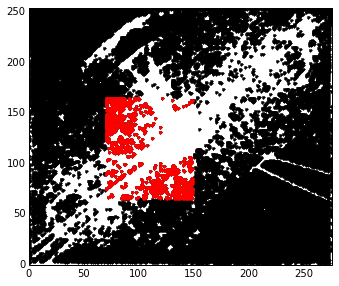

In [27]:
#Visualize the different pages of the pattern
row = 1; col = 1
ymax = after.shape[0]
pxmin = pxperpg_x[row,:col].sum()
pxmax = pxperpg_x[row,:col].sum()+pxperpg_x[row,col]-1
pymin = pxperpg_y[:row,col].sum()
pymax = pxperpg_y[:row,col].sum()+pxperpg_y[row,col]-1
rowmin = pymin; rowmax = pymax
colmin = pxmin; colmax = pxmax
print pxmin,pxmax,pymin,pymax
print "pxperpg_y[:row,col].sum()",pxperpg_y[row:,col].sum()
print ymax-pxperpg_y[row,col]
fig = figure(5,figsize=(5*sizey/sizex,5*sizex/sizey))

x,y = locate_color(after,(0,0,0))
plt.plot(x,ymax-y+1,'k.')


x2,y2 = locate_color(after[rowmin:rowmax+1,colmin:colmax+1,...],(0,0,0))
plt.plot(x2+pxmin,ymax-y2-pymin+1,'r.')

plt.xlim(0,276)
plt.ylim(0,254)


In [28]:
import datetime
from matplotlib.backends.backend_pdf import PdfPages

In [33]:
def make_pattern(after,summary):
    wp,hp = 7.5,10. #printable paper width,height
    cmperinch = 2.54 #cm
    boxespercm = 4 # 0.25mm per side
    numpix_x = int(np.floor(wp*cmperinch*boxespercm))
    numpix_y = int(np.floor(hp*cmperinch*boxespercm))
    gridx = 80 #max px in x direction
    gridy = 100 #max px in y direction
    border = 10 #grid box border
    xmax = after.shape[1]
    ymax = after.shape[0]
    pgsx = int(np.ceil(xmax/float(gridx)))
    pgsy = int(np.ceil(ymax/float(gridy)))
    pxperpg_x = np.zeros([pgsy, pgsx],dtype=int)+80
    pxperpg_y = np.zeros([pgsy, pgsx],dtype=int)+100
    #leftmost pages have 70 px in x, next n have 80 each, rightmost have remainder
    #topmost pages have 90 px in x, next n have 100 each, bottommost have remainder
    pxperpg_x[:,0] -= 10; pxperpg_x[:,-1] = xmax-pxperpg_x[0,0:-1].sum()
    pxperpg_y[0,:] -= 10; pxperpg_y[-1,:] = ymax-pxperpg_y[0:-1,0].sum()  

    #http://matplotlib.org/examples/pylab_examples/multipage_pdf.html
    # Create the PdfPages object to which we will save the pages:
    # The with statement makes sure that the PdfPages object is closed properly at
    # the end of the block, even if an Exception occurs.
    with PdfPages('Pattern.pdf') as pdf:
        page = 0
        for row in range(pgsy): #row=y
            for col in range(pgsx): #col=x
                page += 1
                pxmin = pxperpg_x[row,:col].sum()
                pxmax = pxperpg_x[row,:col].sum()+pxperpg_x[row,col]-1
                pymin = pxperpg_y[:row,col].sum()
                pymax = pxperpg_y[:row,col].sum()+pxperpg_y[row,col]-1

                rowmin = pymin; rowmax = pymax
                colmin = pxmin; colmax = pxmax
                pltxmin = pxmin; pltxmax = pxmax
                pltymin = pymax; pltymax = pymin
                if col == 0:
                    pltxmin -= border
                if row == 0: 
                    pltymax -= border
                if col == pgsx-1:
                    pltxmax = gridx*pgsx
                if row == pgsy-1:
                    pltymin = gridy*pgsy
    
                plt.figure(row,figsize=(wp,hp))
                ax = plt.axes([0.025, 0.025, 0.95, 0.95])
                ax.set_xlim(pltxmin,pltxmax) #Row,Col vs. x,y
                ax.set_ylim(pltymin,pltymax) #with padding around image
                ax.xaxis.set_major_locator(plt.MultipleLocator(10.))
                ax.xaxis.set_minor_locator(plt.MultipleLocator(1.))
                ax.yaxis.set_major_locator(plt.MultipleLocator(10.))
                ax.yaxis.set_minor_locator(plt.MultipleLocator(1.))
                ax.grid(which='major', axis='x', linewidth=0.75, linestyle='-', color='0.75')
                ax.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.75')
                ax.grid(which='major', axis='y', linewidth=0.75, linestyle='-', color='0.75')
                ax.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.75')
                #ax.set_xticklabels([])
                #ax.set_yticklabels([])
                count = 0
                for (skeins, floss, name, oldcolor, matchedcolor) in summary:
                    mc = mpc[count]
                    if (oldcolor.all() == 0):
                        x,y = locate_color(after[rowmin:rowmax+1,colmin:colmax+1,...],oldcolor)
                        #Use small dot for black pixels
                        plt.plot(x+pxmin+0.5,y+pymin+0.5, color='k',marker='.', lw = 0,markersize=2)
                    else:
                        x,y = locate_color(after[rowmin:rowmax+1,colmin:colmax+1,...],oldcolor)
                        plt.plot(x+pxmin+0.5,y+pymin+0.5, marker="$%s$" % symbol[count], lw = 0,markersize=3)
                        count += 1
    
                ax.text(pltxmin+40,pltymin+4,"$\copyright$ 2015 StitchIt - https://github.com/dedx/Stitchit")
                ax.text(pltxmin,pltymin+4,"(%d,%d) pg %d of %d"%(row,col,page,pgsx*pgsy))
                pdf.savefig(papertype='letter',bbox_inches='tight')
                print "Adding page %d"%page
                plt.close()
                
                # We can also set the file's metadata via the PdfPages object:
                d = pdf.infodict()
                d['Title'] = 'Stitchit Pattern'
                d['Author'] = 'Jennifer Klay'
                d['Subject'] = 'Multi-page cross-stitch pattern file'
                d['Keywords'] = 'PdfPages multipage keywords author title subject'
                d['CreationDate'] = datetime.datetime(2015, 6, 9)
                d['ModDate'] = datetime.datetime.today()

In [39]:
#Note: Need to pass the replaced color image and a revised "summary" with the new colors in it.
make_pattern(after,summary)

Adding page 1
Adding page 2
Adding page 3
Adding page 4
Adding page 5
Adding page 6
Adding page 7
Adding page 8
Adding page 9
Adding page 10
Adding page 11
Adding page 12


#To-Dos:

1. Figure out how to provide the floss color dictionary to the K-means algorithm for semi-supervised clustering.
2. Update the summary table after replacing the colors.  Use the replaced color image to make the pattern.
2. Finish the multipage pattern to include 
   * cover page with original/replaced color image
   * instruction page with floss count, color <--> symbol key
3. Fix the symbols to print better - more legible

##### 